In [1]:
ENV["GKS_ENCODING"] = "utf-8"
#using GroupedErrors
using JuliaDB, Plots, StatsPlots, StatsBase, Interpolations, Statistics, LaTeXStrings, Random, Distributions,
JLD2, Colors, Plots.PlotMeasures, Dates, LsqFit
gr()
path = chop(pwd(),tail=7)

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260


"C:\\Users\\lucy_\\bats\\radiotrack\\"

In [2]:
t = loadtable(string(path, "data/radiotrack.csv"));

In [3]:
t = loadtable(string(path, "data/radiotrack.csv"))

t = JuliaDB.pushcol(t, :x_displacement, select(t, (:X, :start_x) => row -> row.X-row.start_x))
t = JuliaDB.pushcol(t, :y_displacement, select(t, (:Y, :start_y) => row -> row.Y-row.start_y))

t = JuliaDB.pushcol(t, :SD, (:X, :start_x, :Y, :start_y) => row -> (row.X-row.start_x)^2 + (row.Y-row.start_y)^2)
sunset = 21*3600 .+ 60 .*[3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 24, 25, 25, 26, 27, 27, 28];
days = unique(select(t, :studyday));



┌ Warning: `pushcol(t, key::Union{Int, Symbol}, val)` is deprecated, use `transform(t, key => val)` instead.
│   caller = top-level scope at In[3]:2
└ @ Core In[3]:2
┌ Warning: `pushcol(t, key::Union{Int, Symbol}, val)` is deprecated, use `transform(t, key => val)` instead.
│   caller = top-level scope at In[3]:4
└ @ Core In[3]:4
┌ Warning: `pushcol(t, key::Union{Int, Symbol}, val)` is deprecated, use `transform(t, key => val)` instead.
│   caller = top-level scope at In[3]:5
└ @ Core In[3]:5


In [4]:
θ = []
r = []
for (x,y) in zip(JuliaDB.select(t,:x_displacement),JuliaDB.select(t,:y_displacement))
    if x < 0
        append!(θ, atan(y/x) + pi) 
    else
        append!(θ, atan(y/x))
    end
    append!(r,sqrt(x^2+y^2))
end

r = r[isnan.(θ) .!= 1.0]
θ = θ[isnan.(θ) .!= 1.0]
#r = r[r .> 0.0]
#θ = θ[r .> 0.0];
θ[θ .< 0] .= θ[θ .< 0] .+ 2pi
#r = r[θ .> 0];
#θ = θ[θ .> 0];


randθ = []
randr = []
for (x,y) in zip(rand(-3000:3000,100000),rand(-3000:3000,100000))
    if x < 0
        append!(randθ, atan(y/x) + pi) 
    else
        append!(randθ, atan(y/x))
    end
    append!(randr,sqrt(x^2+y^2))
end

randr = randr[isnan.(randθ) .!= 1.0]
randθ = randθ[isnan.(randθ) .!= 1.0]
#r = r[r .> 0.0]
#θ = θ[r .> 0.0];
randθ[randθ .< 0] .= randθ[randθ .< 0] .+ 2pi
#r = r[θ .> 0];
#θ = θ[θ .> 0];

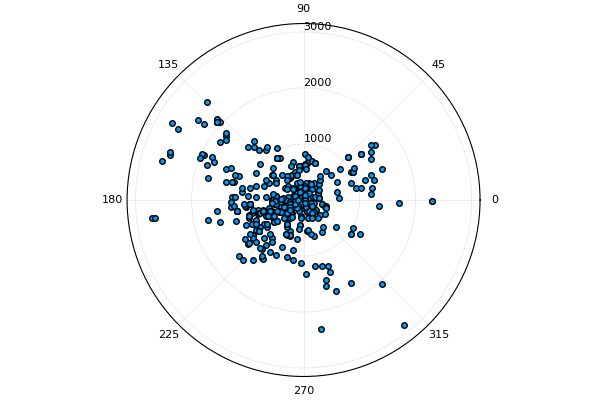

In [33]:
p1 = scatter(θ ,r, proj = :polar, label="")
#p2 = @df t scatter(:x_displacement, :y_displacement, aspect_ratio=1, framestyle = :origin, label="")
#plot(p1,p2,size=(800,500))

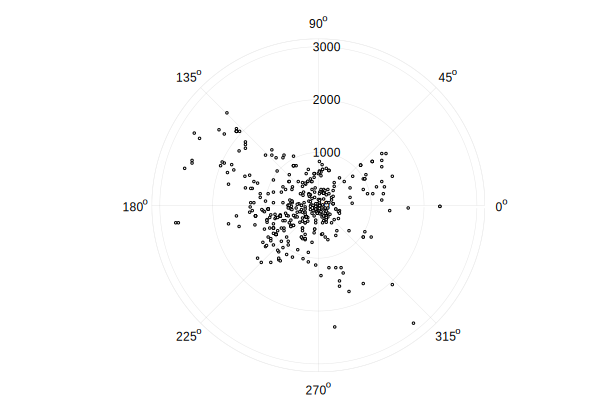

In [49]:
scatter(θ ,r, proj = :polar, label="",markersize=1,markercolor=:white, grid=true, axes_style=:grid, foreground_color_grid=:black, showaxis=true)


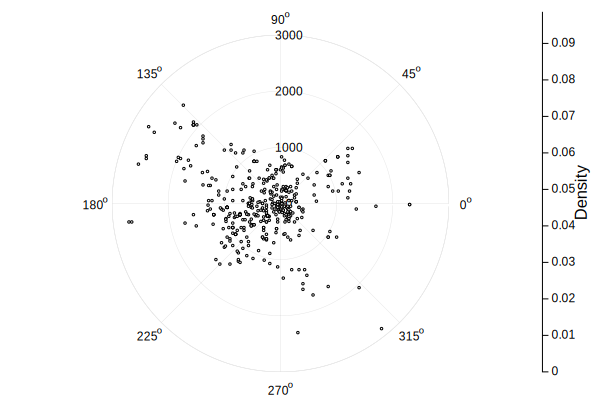

In [62]:
gr()
hist = fit(Histogram, (float.(θ),float.(r)),(0:pi/4:2pi,0:1000:3000))
#p1 = heatmap(h.edges[1],h.edges[2],h.weights')
#scatter!(θ ,r, label="",markersize=1)

centres = ((collect(hist.edges[1])[1:end-1].+collect(hist.edges[1])[2:end])./2,(collect(hist.edges[2])[1:end-1].+collect(hist.edges[2])[2:end])./2)
randh = fit(Histogram, (float.(randθ),float.(randr)),(0:pi/4:2pi,0:1000:3000))
dens = hist.weights'./randh.weights'

p2 = heatmap(centres[1],centres[2],dens, proj=:polar,ylim=(0,3000), c=:blues, grid=true, seriesalpha=0, colorbar_title="Density")
scatter!(θ ,r, proj = :polar, label="",markersize=1,markercolor=:white)
#savefig(p2,"../figs/polar_histogram.pdf")
#plot(p1,p2,size=(800,350))

In [11]:
timesteps = []
num_traj = 0 
for i in unique(select(t, :BatID))
    for (idx,j) in enumerate(unique(select(filter(x -> x == i , t; select = :BatID), :studyday)))
        A_t = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Time)
        tfs = hour.(DateTime.(A_t, "HH:MM:SS"))*3600 + minute.(DateTime.(A_t, "HH:MM:SS"))*60 + second.(DateTime.(A_t, "HH:MM:SS")) .- sunset[findfirst(x-> x==j, days)]   
        tfs[findall(tfs .< -10000)] .+= 24*3600
        tfs[findall(tfs.<0)] .= 0
        if length(tfs)>1            
            #print(tfs[2:end].-tfs[1:end-1],"\n")
            append!(timesteps, tfs[2:end].-tfs[1:end-1])
        end
        num_traj += 1
    end
end
timesteps = timesteps*60;

In [13]:
gr()
t2 = loadtable(string(path, "data/radiotrack_roosts.csv"))
scatter((select(t,:X).-minimum(select(t,:X)))./1e3 .+ 0.1, (select(t,:Y).- minimum(select(t,:Y)))./1e3, markersize=4, label="Bat locations")
scatter!((select(t2,:Roost_x).- minimum(select(t,:X)))./1e3 .+ 0.1,(select(t2,:Roost_y).- minimum(select(t,:Y)))./1e3, markersize=8, label="Day roosts",marker=:diamond)
plot!(legend=:outertopright, aspect_ratio=1,xlabel="x (km)",ylabel="y (km)",tickfontsize=12, legendfontsize=12, guidefontsize=12, grid=:off,
    size=(600,400), margin=10px)
savefig(string(path, "figs/track_locations.png"))

In [14]:
i = 1
plot(
    markersize=8, 
    size=(800,500), grid=false,
    ylims=(0,1.6),
    tickfontsize=15, guidefontsize=15, legendfontsize=12, margin=10mm)

colours = [:fuchsia,:greenyellow,:blue,:red,:orange,:black]
for (idx,j) in enumerate(unique(select(filter(x -> x == i , t; select = :BatID), :studyday)))
    plot!((select(filter(x -> (x.BatID == i)&& (x.studyday ==j),t),:X).- minimum(select(t,:X)))./1e3, 
        (select(filter(x -> (x.BatID == i)&& (x.studyday ==j),t),:Y).- minimum(select(t,:Y)))./1e3, 
        width=2, label=string("Day ",j), color=colours[idx])
end
for (idx,j) in enumerate(unique(select(filter(x -> x == i , t; select = :BatID), :studyday)))
    scatter!((select(filter(x -> (x.BatID == i)&& (x.studyday ==j),t),:X).- minimum(select(t,:X)))./1e3, 
        (select(filter(x -> (x.BatID == i)&& (x.studyday ==j),t),:Y).- minimum(select(t,:Y)))./1e3, 
        markersize=4, label="", color=colours[idx])
end
scatter!((select(t2,:Roost_x).- minimum(select(t,:X)))[1:2]./1e3 .+ 0.1,
    (select(t2,:Roost_y).- minimum(select(t,:Y)))[1:2]./1e3, markersize=8, 
    label="Roosts",marker=:diamond, color=:cadetblue1)
plot!(legend=:outertopright, aspect_ratio=1,xlabel="x (km)",ylabel="y (km)",markersize=8, 
    size=(800,500), grid=false,
    tickfontsize=15, guidefontsize=15, legendfontsize=12, 
    margin=10mm, ylims=[0 5])
savefig(string(path, "figs/bat1_locations.png"))

In [15]:
i = 5
j = 6
idx = j
A_t = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Time)
 
xdis1 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :x_displacement)
ydis1 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :y_displacement);

i = 6
j = 8
idx = j
A_t = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Time)
 
xdis2 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :x_displacement)
ydis2 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :y_displacement);


i = 6
j = 10
idx = j
A_t = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Time)
 
xdis3 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :x_displacement)
ydis3 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :y_displacement);

i = 7
j = 8
idx = j
A_t = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Time)
 
xdis4 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :x_displacement)
ydis4 = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :y_displacement);



In [16]:
gr()
plt = hline([0,0], label="", color=:black)
vline!([0,0], label="", color=:black)
plot!(xdis1, ydis1, label="Regression", color=:blue)
scatter!(xdis1,ydis1, label="Recorded points", color=:blue, markersize=5)
plot!(xdis2, ydis2, label="Regression", color=:orange)
scatter!(xdis2,ydis2, label="Recorded points", color=:orange, markersize=5)
plot!(xdis3, ydis3, label="Regression", color=:red)
scatter!(xdis3,ydis3, label="Recorded points", color=:red, markersize=5)
plot!(xdis4, ydis4, label="Regression", color=:black)
scatter!(xdis4,ydis4, label="Recorded points", color=:black, markersize=5)



plot!(grid=false, aspect_ratio=1, showaxis=false, legend=false,
    size=(500,500),
    tickfontsize=18, guidefontsize=20, legendfontsize=10)

savefig(string(path, "figs/Track_interpolations.png"))

In [17]:
dt = 60.
times = []
sdists = []
xdists = []
ydists = []
ts = []
l = []
batID = []
batday = []
for i in unique(select(t, :BatID))
    for (idx,j) in enumerate(unique(select(filter(x -> x == i , t; select = :BatID), :studyday)))
           roost = [select(filter(x -> (x.BatID == i) && (x.studyday ==(j+1)), t2), :Roost_x)  select(filter(x -> (x.BatID == i) && (x.studyday ==j+1), t2), :Roost_y)]
             A_t = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Time)
            if length(roost) >0
            A_t = select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Time)
            tfs = hour.(DateTime.(A_t, "HH:MM:SS"))*3600 + minute.(DateTime.(A_t, "HH:MM:SS"))*60 + second.(DateTime.(A_t, "HH:MM:SS")) .- sunset[findfirst(x-> x==j, days)]   
            tfs[findall(tfs .< -10000)] .+= 24*3600
            tfs[findall(tfs.<0)] .= 0
            if length(tfs) > 1
                knots = (tfs,)
                itpx = interpolate(knots, select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :X).-roost[1], Gridded(Linear()))
                itpy = interpolate(knots, select(filter(x -> (x.BatID == i) && (x.studyday ==j), t), :Y).-roost[2], Gridded(Linear()))
                for (j,t) in enumerate(dt:dt:8*3600)
                    if t < tfs[end] && t > tfs[1]
                        append!(ts, t)
                        append!(sdists, itpx(t)^2+itpy(t)^2)
                        append!(xdists, itpx(t))
                        append!(ydists, itpy(t))
                        append!(batID, i)
                        append!(batday,idx)
                    end
                end
            end
        end
    end
end

hours = ts./3600;
t3 = table((ID=batID, day=batday, t=ts, hour=hours, sd=sdists, xd=xdists, yd=ydists));

InterruptException: InterruptException:

In [18]:
plt = scatter(1, xlim=(-3000,2000), ylim=(-1000,1000),
                title = "Bats", marker = 2, label="")
#sunset 21:10
@gif for time = 300.0:60.0:sort(unique(select(t3,:t)))[end]#sort(unique(select(t3,:t)))[2:end]
    @df filter(x->(x.t < time)&&(x.ID == 1),t3) plot(:xd,:yd, group=(:day),
        label="", title=string(time/60, ":"),
        xlim=(-1500,1500), ylim=(-1000,1000), grid=false,foreground_color_guide=:white)
    @df filter(x->(x.t < time)&&(x.ID == 1),t3) scatter!(:xd,:yd, group=(:day),
        label="", title=string(time/60, ":"),
        xlim=(-1500,1500), ylim=(-1000,1000), grid=false,foreground_color_guide=:white)
end

InterruptException: InterruptException:

In [19]:
# sqrt(var(x, corrected=true) / length(x)).

meansd = []
meanxd = []
meanyd = []
meand = []
stdsd = []
varsd = []
lngth = [] 
sstot = 0
for (i, tps) in enumerate(dt:dt:maximum(ts))
    append!(meansd, mean(sdists[ts.==tps]))
    append!(meanxd, mean(xdists[ts.==tps]))
    append!(meanyd, mean(ydists[ts.==tps]))
    append!(meand, mean(xdists[ts.==tps].+ydists[ts.==tps]))
    append!(stdsd, Statistics.std(sdists[ts.==tps]))
    append!(varsd, StatsBase.var(sdists[ts.==tps]))
    append!(lngth, length(sdists[ts.==tps]))
end
semsd = sqrt.(varsd./lngth);
semsd[isnan.(semsd)] .= 0;

InterruptException: InterruptException:

In [20]:
t = dt:dt:maximum(ts)
@save "radiotrack.jld2" t meansd semsd stdsd

InterruptException: InterruptException:

In [21]:
T = 4.19 *10^3
@. model(t, D) = 4*D[1]*t+D[2]
xdata = select(filter(x -> (x.t <T),t3), :t)
ydata = select(filter(x -> (x.t < T), t3), :sd)
D0 = [100., 100.0]
fit_ = curve_fit(model, xdata, ydata, D0)
D_estimate = coef(fit_)
coef(fit_), confidence_interval(fit_, 0.05)

InterruptException: InterruptException:

In [22]:
scatter(t,meansd)

InterruptException: InterruptException:

In [23]:
T = 4.19 *10^3
@. model(t, p) = p[1]*t + p[2]
xdata = select(filter(row -> (row.t > T), t3), :t)
ydata = select(filter(row -> (row.t > T), t3), :sd)
p0 = [1., 1.]
fit_ = curve_fit(model, xdata, ydata, p0)
p = coef(fit_)

dt_sim = 10
msds_linear = []

for (i, tps) in enumerate(dt:dt:maximum(ts))
    if tps<T
        append!(msds_linear, 4*D_estimate[1]*tps+D_estimate[2])
    else
        append!(msds_linear,(p[1]*tps + p[2]))
    end
end


semsd = sqrt.(varsd./lngth);
semsd[isnan.(semsd)] .= 0;


InterruptException: InterruptException:

In [24]:
p

InterruptException: InterruptException:

In [25]:

T = 4.19 *10^3
@. model(t, p) = p[1]*t^2 + p[2]*t + p[3]
xdata = select(filter(row -> (row.t > T), t3), :t)
ydata = select(filter(row -> (row.t > T), t3), :sd)
p0 = [1.,1.,1.]
fit_ = curve_fit(model, xdata, ydata, p0)
p = coef(fit_)

dt_sim = 10
msds_quadratic = []

for (i, tps) in enumerate(dt:dt:maximum(ts))
    if tps<T
        append!(msds_quadratic, 4*D_estimate[1]*tps+D_estimate[2])
    else
        append!(msds_quadratic,(p[1]*tps^2 + p[2]*tps + p[3]))
    end
end

semsd = sqrt.(varsd./lngth);
semsd[isnan.(semsd)] .= 0;



InterruptException: InterruptException:

In [26]:
T = 4.19 *10^3
@. model(t, p) = p[1]*t^2 + p[2]*t + p[3]
xdata = select(filter(row -> (row.t > T), t3), :t)
ydata = select(filter(row -> (row.t > T), t3), :sd)
p0 = [1.,1.,1.]
fit_ = curve_fit(model, xdata, ydata, p0)
p = coef(fit_)

dt_sim = 10
msds_quadratic = []

for (i, tps) in enumerate(dt:dt:maximum(ts))
    if tps<T
        append!(msds_quadratic, 4*D_estimate[1]*tps+D_estimate[2])
    else
        append!(msds_quadratic,(p[1]*tps^2 + p[2]*tps + p[3]))
    end
end

semsd = sqrt.(varsd./lngth);
semsd[isnan.(semsd)] .= 0;


InterruptException: InterruptException:

In [27]:
sstot = 0
ssres_linear = 0
ssres_quadratic = 0
ssres_simulation = 0
    for (i,msd) in enumerate(meansd)  
        sstot += (msd - mean(meansd))^2
        ssres_linear += (msds_linear[i]-msd)^2
        ssres_quadratic += (msds_quadratic[i]-msd)^2
    end


r2_quadratic = 1 - ssres_quadratic/sstot
r2_linear = 1 - ssres_linear/sstot

InterruptException: InterruptException:

In [28]:
plot(xlabel=string("Time from sunset (hours)"), ylabel="MSD (km²)", 
    markersize=8, color=:red, label="Mean squared distance",
    size=(800,500), grid=false,
    ylims=(0,1.6),
    tickfontsize=15, guidefontsize=15, legendfontsize=12, margin=10mm)
scatter!((dt:dt:maximum(ts))./3600., meansd./10^6, label="Mean",
    ribbon=semsd./10^6, fill=:orange, 
    markersize=8, color=:red)
scatter!((dt:dt:maximum(ts))./3600., meansd./10^6, label="Standard error",
    ribbon=semsd.-semsd, fill=:orange, marker = :square, markerstrokecolor=:white,
    markersize=0, color=:orange)
scatter!((dt:dt:maximum(ts))./3600., meansd./10^6, label="",
    ribbon=semsd./10^6, fill=:orange, 
    markersize=8, color=:red)
#plot!()

savefig(string(path, "figs/RadioTrack_MSD.png"))

In [29]:
plot(xlabel=string("Time from sunset (hours)"), ylabel="MSD (km²)", 
    markersize=8, color=:red,
    ylims=(0,1.6),
    size=(800,500), grid=false,
    tickfontsize=17, guidefontsize=22, margin=10mm)
scatter!((dt:dt:maximum(ts))./3600., meansd./10^6, label="",
    ribbon=semsd./10^6, fill=:orange, 
    markersize=8, color=:red)
plot!((dt:dt:maximum(ts))./3600,msds_quadratic./10^6, label="",
    line = (:line, :solid, 1, 3, :blue))

savefig(string(path, "figs/RadioTrack_MSD_fit.png"))